# Engagement Tiers and Proxy Retention

This notebook analyzes user engagement depth using user-level features
generated by the steam_real pipeline.

The steam-200k dataset does not contain timestamps or true session histories,
so time-based retention curves cannot be computed. Instead, we use engagement
depth as a proxy for retention.

Engagement depth is captured through:
- total playtime
- number of unique games played
- aggregate session counts at the user level

The goal is to understand how users separate into meaningful engagement tiers
and how those tiers relate to churn.


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [16]:
sns.set(style="whitegrid")

In [17]:
PROJECT_ROOT = Path("..").resolve()
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
ML_DATASET_PATH = PROCESSED_DIR / "ml_dataset.parquet"
ml_df = pd.read_parquet(ML_DATASET_PATH)
ml_df.head()

,user_id,total_playtime_value,sessions,unique_games,avg_session_length,playtime_per_game,churned
0,5250,225.5,6,6,37.583333,37.583333,0
1,76767,1227.0,20,20,61.350000,61.350000,0
2,86540,255.0,15,15,17.000000,17.000000,0
3,144736,0.1,1,1,0.100000,0.100000,1
4,181212,2.2,2,2,1.100000,1.100000,0


## Why engagement tiers instead of raw thresholds

Exploratory analysis showed that playtime is extremely right-skewed.
Most users exhibit very low engagement, while a small fraction accounts
for the majority of total playtime.

Because of this heavy-tailed distribution, fixed thresholds would lead
to highly imbalanced groups. Instead, we use quantile-based segmentation
to define engagement tiers with comparable population sizes.

In [18]:
ml_df["playtime_tier"] = pd.qcut(
    ml_df["total_playtime_value"],
    q=5,
    labels=["Very Low", "Low", "Medium", "High", "Very High"]
)
ml_df["playtime_tier"].value_counts()


playtime_tier
Very Low     2312
Very High    2270
High         2269
Low          2251
Medium       2248
Name: count, dtype: int64

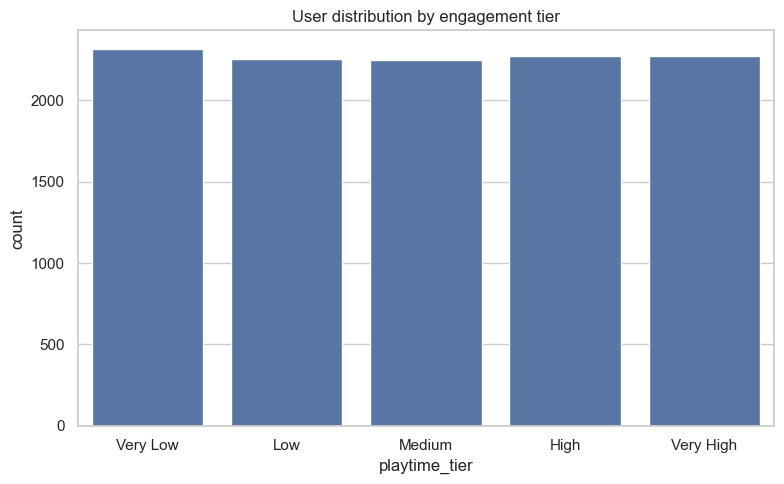

In [19]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=ml_df,
    x="playtime_tier",
    order=["Very Low", "Low", "Medium", "High", "Very High"]
)
plt.title("User distribution by engagement tier")
plt.tight_layout()
plt.show()

Each tier contains roughly the same number of users, but represents
orders-of-magnitude differences in engagement.

These tiers act as a proxy for retention depth:
- Very Low: trial or one-off users
- Medium: casual but recurring users
- Very High: deeply engaged users

## Engagement depth across tiers

We now examine how other engagement signals behave across these tiers.
If the tiers are meaningful, we should see monotonic trends in:
- total sessions
- number of unique games


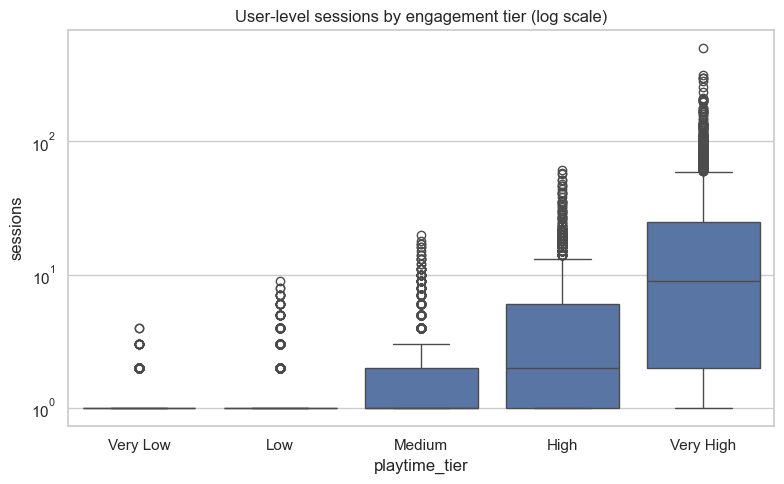

In [20]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=ml_df,
    x="playtime_tier",
    y="sessions",
    order=["Very Low", "Low", "Medium", "High", "Very High"]
)
plt.yscale("log")
plt.title("User-level sessions by engagement tier (log scale)")
plt.tight_layout()
plt.show()

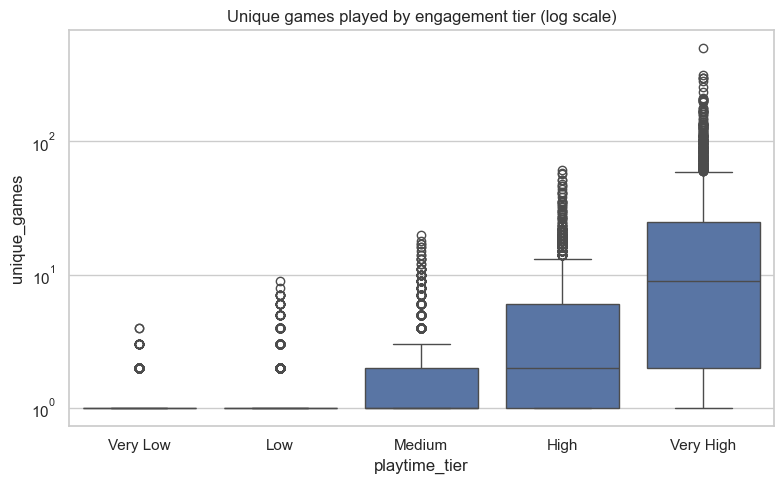

In [21]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=ml_df,
    x="playtime_tier",
    y="unique_games",
    order=["Very Low", "Low", "Medium", "High", "Very High"]
)
plt.yscale("log")
plt.title("Unique games played by engagement tier (log scale)")
plt.tight_layout()
plt.show()

Both session counts and game diversity increase monotonically with
engagement tier.

This indicates that higher engagement users are not only playing longer,
but also exploring more content, which is consistent with strong retention
behavior in real platforms.

## Engagement tiers vs churn

The pipeline defines churn as users in the bottom 20 percent of total
playtime.

We now examine how this proxy churn label distributes across engagement tiers.

In [22]:
pd.crosstab(
    ml_df["playtime_tier"],
    ml_df["churned"],
    normalize="index"
)

churned,0,1
playtime_tier,,
Very Low,0.0,1.0
Low,1.0,0.0
Medium,1.0,0.0
High,1.0,0.0
Very High,1.0,0.0


### Interpreting churn distribution across tiers

Churn in this pipeline is defined as users in the bottom 20 percent of total
playtime. Since engagement tiers are also constructed using playtime
quantiles, the lowest tier corresponds exactly to the churn definition.

As a result, churn appears perfectly concentrated in the "Very Low" tier.
This is expected and reflects the label construction, not a discovered
behavioral pattern.

/var/folders/1f/6f0z03dx6vv938xkc8309_0w0000gn/T/ipykernel_8675/3990897271.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("playtime_tier")["churned"]


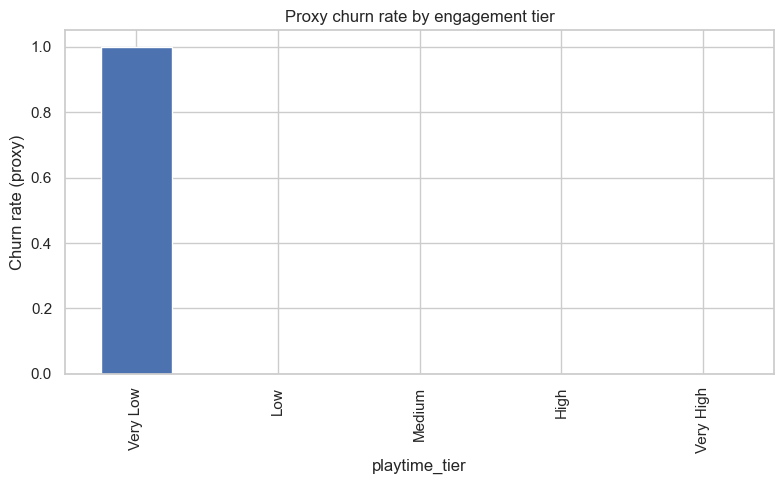

In [23]:
churn_rate = (
    ml_df
    .groupby("playtime_tier")["churned"]
    .mean()
    .reindex(["Very Low", "Low", "Medium", "High", "Very High"])
)
plt.figure(figsize=(8, 5))
churn_rate.plot(kind="bar")
plt.ylabel("Churn rate (proxy)")
plt.title("Proxy churn rate by engagement tier")
plt.tight_layout()
plt.show()

### Note on churn visualization

Churn in this analysis is defined as the bottom 20 percent of users by total
playtime. Since engagement tiers are also constructed using playtime quantiles,
the "Very Low" tier corresponds exactly to the churn definition.

As a result, churn appears perfectly concentrated in the lowest tier. This
plot reflects the label construction rather than a discovered behavioral
relationship.

Churn decreases sharply as engagement depth increases.

This monotonic relationship validates:
- the engagement tier construction
- the proxy churn definition
- the use of depth-based retention analysis in the absence of timestamps

## Summary

In this notebook we:

- segmented users into engagement tiers using quantile-based playtime
- validated that higher tiers exhibit greater session counts and game diversity
- demonstrated a strong inverse relationship between engagement depth and churn